In [1]:
#data sources, etc
import pandas as pd
import numpy as np
from numpy import empty, vstack, array

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import math, time
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
cData=pd.read_csv('127compiledDailyData127.csv') #.drop(columns='Unnamed: 0')
cData

,date,open,high,low,close,volume,ticker
0,2020-06-08,9.7000,9.830,9.4900,9.53,6083313.0,SRTY
1,2020-06-05,9.9600,10.270,9.6500,10.13,11205729.0,SRTY
2,2020-06-04,11.6399,11.780,11.2150,11.46,8088398.0,SRTY
3,2020-06-03,11.7200,11.850,11.0900,11.41,9058773.0,SRTY
4,2020-06-02,12.3800,12.790,12.1700,12.30,6600797.0,SRTY
...,...,...,...,...,...,...,...
12619,2020-01-22,56.8800,57.030,56.6500,56.85,4256610.0,KRE
12620,2020-01-21,57.1400,57.405,56.7901,56.80,5027864.0,KRE
12621,2020-01-17,57.9100,57.950,57.4400,57.54,8222643.0,KRE
12622,2020-01-16,56.9000,57.480,56.8900,57.41,7366494.0,KRE


In [3]:
cData['ticker'].unique()

array(['SRTY', 'CAL', 'TEN', 'OSUR', 'APY', 'SABR', 'OVV', 'CIM', 'RUTH',
       'LILAK', 'UAA', 'MAC', 'TGI', 'SVC', 'MT', 'EB', 'AA', 'GPS',
       'XHR', 'PCG', 'AMKR', 'AZUL', 'ROIC', 'HBI', 'RLJ', 'PK', 'BPYU',
       'DENN', 'JBLU', 'BLMN', 'UGAZ', 'HST', 'KEY', 'FAZ', 'DLPH', 'SRG',
       'CXP', 'RRR', 'YEXT', 'PEB', 'AKR', 'PVAC', 'HOMB', 'ELY', 'DXD',
       'CUK', 'EPRT', 'CNP', 'PPC', 'XRX', 'AAL', 'GAN', 'NMIH', 'PLAY',
       'DFEN', 'SEAS', 'HA', 'OUT', 'VVV', 'TZA', 'JETS', 'OXY', 'ERX',
       'CCL', 'MGM', 'SDOW', 'DBX', 'WRI', 'NCLH', 'CCC', 'JWN', 'SAVE',
       'KTB', 'FSCT', 'USFD', 'AU', 'ILF', 'HGV', 'CHK', 'TRIP', 'PD',
       'CIT', 'HSBC', 'KSS', 'REM', 'YELP', 'HTA', 'CAKE', 'EWG', 'KDP',
       'PEAK', 'GM', 'SCHC', 'CAR', 'APLS', 'WFC', 'NAIL', 'WORK', 'KHC',
       'DUST', 'SPR', 'VTIQ', 'DAL', 'ZTO', 'RWM', 'TMF', 'CUZ', 'COLD',
       'TCBI', 'NKLA', 'KBE', 'WYND', 'DT', 'LUV', 'ADPT', 'URTY', 'ARES',
       'FR', 'WERN', 'UAL', 'ALK', 'SCHW', 'EFV', 'R

In [27]:
def ratioForwardMA (df,ma=5,maCol='open', forward=1):
    compiledDF=pd.DataFrame()
    for ticker in df['ticker'].unique():
        dfSub=df[df['ticker']==ticker]
        dfRatio=pd.DataFrame()
        
        dfRatio['open']=dfSub['open']/dfSub['open'].iloc[-1]
        dfRatio['high']=dfSub['high']/dfSub['open'].iloc[-1]
        dfRatio['low']=dfSub['low']/dfSub['open'].iloc[-1]
        dfRatio['close']=dfSub['close']/dfSub['open'].iloc[-1]
       
    
        dfRatio['upperShadow']=(dfRatio['high']-dfRatio[['open','close']].max(axis=1))
        dfRatio['lowerShadow']=(dfRatio['low']-dfRatio[['open','close']].min(axis=1))
        dfRatio['body']=dfRatio['close']-dfRatio['open']

        dfRatio['openF'+str(forward)]=dfRatio['open'].shift(forward)
        dfRatio['highF'+str(forward)]=dfRatio['high'].shift(forward)
        dfRatio['lowF'+str(forward)]=dfRatio['low'].shift(forward)
        dfRatio['closeF'+str(forward)]=dfRatio['close'].shift(forward)
        
        dfRatio['MA'+str(ma)]=dfRatio[maCol].rolling(window=ma).mean().shift(-ma+1)
        dfRatio.insert(0,'date',dfSub['date'])
        dfRatio.insert(1,'ticker', dfSub['ticker'])
        
        dfRatio=dfRatio.iloc[::-1]
        compiledDF=compiledDF.append(dfRatio)
        
    compiledDF=compiledDF.dropna()
    return compiledDF
        

In [28]:
rfmaDF=ratioForwardMA(cData)
rfmaDF

,date,ticker,open,high,low,close,upperShadow,lowerShadow,body,openF1,highF1,lowF1,closeF1,MA5
95,2020-01-22,SRTY,0.964105,0.980370,0.957375,0.975883,0.004487,-0.006730,0.011778,0.983735,1.010656,0.968873,0.975322,0.962759
94,2020-01-23,SRTY,0.983735,1.010656,0.968873,0.975322,0.026921,-0.006450,-0.008413,0.966910,1.032529,0.966910,1.014582,0.959506
93,2020-01-24,SRTY,0.966910,1.032529,0.966910,1.014582,0.017947,0.000000,0.047672,1.060437,1.067190,1.030286,1.047672,0.961189
92,2020-01-27,SRTY,1.060437,1.067190,1.030286,1.047672,0.006753,-0.017386,-0.012765,1.027482,1.033090,1.011217,1.021312,0.987522
91,2020-01-28,SRTY,1.027482,1.033090,1.011217,1.021312,0.005609,-0.010095,-0.006169,1.016826,1.039260,1.009534,1.039260,1.000534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12529,2020-06-01,KRE,0.675405,0.689127,0.667840,0.678220,0.010908,-0.007565,0.002815,0.689655,0.694757,0.669775,0.676108,0.684483
12528,2020-06-02,KRE,0.689655,0.694757,0.669775,0.676108,0.005102,-0.006334,-0.013547,0.695461,0.723082,0.694053,0.715165,0.693913
12527,2020-06-03,KRE,0.695461,0.723082,0.694053,0.715165,0.007917,-0.001407,0.019704,0.711999,0.741731,0.703730,0.740852,0.693103
12526,2020-06-04,KRE,0.711999,0.741731,0.703730,0.740852,0.000880,-0.008269,0.028853,0.807002,0.811400,0.777973,0.783779,0.690042


In [50]:
rfmaDF.to_csv('127CalculatedDataFrame.csv')

In [51]:
import plotly.graph_objects as go

ticker='SRTY'
dfChart = rfmaDF[rfmaDF['ticker']==ticker]


fig = go.Figure(data=[go.Candlestick(x=dfChart['date'],
                open=dfChart['open'], high=dfChart['high'],
                low=dfChart['low'], close=dfChart['close'])
                     ])

#add xaxis_type='category' and fig.update_xaxes(autorange="reversed") to remove the datetime gaps
fig.update_layout(xaxis_type='category', xaxis_rangeslider_visible=False, title_text=ticker)
#fig.update_xaxes(autorange="reversed")
fig.show()

dfChart=cData[cData['ticker']==ticker]
fig = go.Figure(data=[go.Candlestick(x=dfChart['date'],
                open=dfChart['open'], high=dfChart['high'],
                low=dfChart['low'], close=dfChart['close'])
                     ])

#add xaxis_type='category' and fig.update_xaxes(autorange="reversed") to remove the datetime gaps
fig.update_layout(xaxis_type='category', xaxis_rangeslider_visible=False, title_text=ticker)
fig.update_xaxes(autorange="reversed")
fig.show()

In [90]:
def accendingTimeOrder (df):
    ndf=df.iloc[::-1].reset_index().drop('index',axis=1)
    return ndf

cDataAssend=accendingTimeOrder(cData)
dfCandle=cDataAssend[['open','high','low','close', 'ticker']]

In [91]:
scaler = MinMaxScaler(feature_range=(-1, 1))
    
scaleCol=['open','high','low', 'close']
dfCandleScaled=pd.DataFrame(scaler.fit_transform(dfCandle[scaleCol].values))
dfCandleScaled.columns=scaleCol
dfCandleScaled['ticker']=dfCandle['ticker']

dfCandleScaled

,open,high,low,close,ticker
0,0.071228,-0.040027,0.174344,0.071628,KRE
1,0.072361,-0.032772,0.186043,0.087000,KRE
2,0.091443,-0.024843,0.197534,0.089467,KRE
3,0.076896,-0.034038,0.183956,0.075424,KRE
4,0.071984,-0.040364,0.181029,0.076372,KRE
...,...,...,...,...,...
12619,-0.768748,-0.786748,-0.748252,-0.769068,SRTY
12620,-0.781217,-0.802607,-0.770816,-0.785958,SRTY
12621,-0.782730,-0.803788,-0.768204,-0.785009,SRTY
12622,-0.814469,-0.829263,-0.800900,-0.810249,SRTY


In [92]:
def crossSec_stocks_split(stock, train_ratio=.8):
    tickers=stock['ticker'].unique()
    tlen=int(np.round(train_ratio*tickers.shape[0]))

    trainT=tickers[:tlen]
    testT=tickers[tlen:]
    
    trainS=pd.DataFrame()
    testS=pd.DataFrame()
    for t in trainT:
        s = stock[stock['ticker']==t]
        trainS=trainS.append(s)
    for t in testT:
        s = stock[stock['ticker']==t]
        testS=testS.append(s)        
    return trainS, testS

In [93]:
def load_data(stock, look_back=20):
    
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    
    x_data = data[:data.shape[0],:-1,:] #[:,:-1,:]
    y_data = data[:data.shape[0],-1,:]

    return [x_data, y_data]

In [94]:
def load_crossSec_stocks_data(stock, look_back=20):
    trainData,testData=crossSec_stocks_split(stock)
    
    lenColNoTicker=len(stock.columns)-1
    
    x_train=empty([0,look_back-1,lenColNoTicker])
    y_train=empty([0,lenColNoTicker])
    x_test=empty([0,look_back-1,lenColNoTicker])
    y_test=empty([0,lenColNoTicker])
    

    for ticker in trainData['ticker'].unique():
        s = stock[stock['ticker']==ticker].drop('ticker',axis=1)
        x_train1, y_train1 = load_data(s, look_back)
        x_train=vstack((x_train, x_train1))
        y_train=vstack((y_train, y_train1))
    for ticker in testData['ticker'].unique():
        s = stock[stock['ticker']==ticker].drop('ticker',axis=1)
        x_test1, y_test1 = load_data(s, look_back)
        x_test=vstack((x_test, x_test1))
        y_test=vstack((y_test, y_test1))
    return x_train, y_train, x_test, y_test

In [95]:
look_back=20
x_train, y_train, x_test, y_test=load_crossSec_stocks_data(dfCandleScaled,look_back=look_back)

In [96]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#train_X = train_X.view([-1, x_train.shape[0], 1])
#test_X = test_X.view([-1, x_test.shape[0], 1])
#train_Y = train_Y.view([y_train.shape[0], 1])

y_train.size(),x_train.size()

(torch.Size([8084, 4]), torch.Size([8084, 19, 4]))

In [97]:
n_steps = look_back-1
batch_size = 1606
#n_iters = 3000
num_epochs = 200 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [98]:
# Build model
#####################
input_dim = 4
hidden_dim = 32
num_layers = 2 
output_dim = 4


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)
10
torch.Size([128, 4])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([4, 32])
torch.Size([4])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [99]:
# Train model
#####################

hist1 = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist1[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.055526722222566605
Epoch  20 MSE:  0.012382636778056622
Epoch  30 MSE:  0.005438824649900198
Epoch  40 MSE:  0.004510368220508099
Epoch  50 MSE:  0.003573599038645625
Epoch  60 MSE:  0.0026963558048009872
Epoch  70 MSE:  0.002527467207983136
Epoch  80 MSE:  0.0023364434018731117
Epoch  90 MSE:  0.002191167091950774
Epoch  100 MSE:  0.0020827134139835835
Epoch  110 MSE:  0.001991536933928728
Epoch  120 MSE:  0.0019080580677837133
Epoch  130 MSE:  0.0018254239112138748
Epoch  140 MSE:  0.0017451973399147391
Epoch  150 MSE:  0.0016667041927576065
Epoch  160 MSE:  0.00158997334074229
Epoch  170 MSE:  0.001515146461315453
Epoch  180 MSE:  0.0014428554568439722
Epoch  190 MSE:  0.0013744498137384653


In [100]:
torch.save(model.state_dict(),'model1.pth')
#model = LSTM(nn.Module)
#model.load_state_dict(torch.load('model1.pth'))
#model.eval()

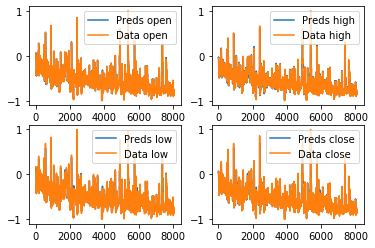

In [101]:
from pylab import *
plt.figure()
subplot(2,2,1)
plt.plot(y_train_pred.detach().numpy()[:,0], label="Preds open")
plt.plot(y_train.detach().numpy()[:,0], label="Data open")
plt.legend()

subplot(2,2,2)
plt.plot(y_train_pred.detach().numpy()[:,1], label="Preds high")
plt.plot(y_train.detach().numpy()[:,1], label="Data high")
plt.legend()

subplot(2,2,3)
plt.plot(y_train_pred.detach().numpy()[:,2], label="Preds low")
plt.plot(y_train.detach().numpy()[:,2], label="Data low")
plt.legend()

subplot(2,2,4)
plt.plot(y_train_pred.detach().numpy()[:,3], label="Preds close")
plt.plot(y_train.detach().numpy()[:,3], label="Data close")
plt.legend()
plt.show()


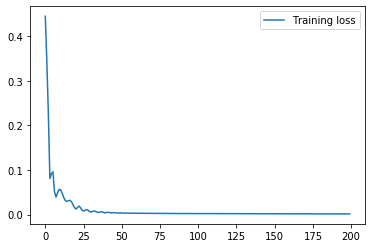

In [103]:
plt.plot(hist1, label="Training loss")
plt.legend()
plt.show()

In [104]:
np.shape(y_train_pred)

torch.Size([8084, 4])

In [105]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred_inv = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_inv = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred_inv = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_inv = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.92 RMSE
Test Score: 1.08 RMSE


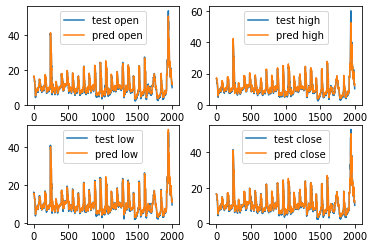

In [106]:
# plot baseline and predictions

subplot(2,2,1)
plt.plot(y_test_inv[:,0], label='test open')
plt.plot(y_test_pred_inv[:,0],label='pred open')
plt.legend()

subplot(2,2,2)
plt.plot(y_test_inv[:,1], label='test high')
plt.plot(y_test_pred_inv[:,1],label='pred high')
plt.legend()

subplot(2,2,3)
plt.plot(y_test_inv[:,2], label='test low')
plt.plot(y_test_pred_inv[:,2],label='pred low')
plt.legend()

subplot(2,2,4)
plt.plot(y_test_inv[:,3], label='test close')
plt.plot(y_test_pred_inv[:,3],label='pred close')
plt.legend()
plt.show()

In [107]:
y_test_inv.shape

(2000, 4)